In [1]:
from credit.data import get_forward_data
from glob import glob
import os
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os.path import join
from credit.xr_sampler import XRSamplerByYear
import yaml


import multiprocessing
from functools import partial

In [ ]:
rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train"
# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/base_skebs_untrained"

# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/fcnn_6_12h"


num_cpus = 15

variable, level = "Qtot", 24




In [3]:
eval_fh = 6
forecast_hours = range(6, 354+ 1, 6)

det_rmse = xr.open_dataset("/glade/derecho/scratch/dkimpara/CREDIT_runs/camulator_weather_rollout/forecast/rmse_lat_lev_unwted_2012-06-05_15dayforecast_16dayinterval.nc")

In [4]:
forecast_day = np.array(forecast_hours) / 24
def plot(std, error, det_rmse, ymax=10, label=None):
    # need to process this properly
    plt.plot(forecast_day, det_rmse[:len(forecast_day)], label="det RMSE", c='0')
    plt.plot(forecast_day, std, label="std", c='tab:orange')
    plt.plot(forecast_day, error, label="rmse", c='b')
    plt.xlabel("Day")
    plt.ylim(0,ymax)
    plt.title(f"{variable}{level if variable in 'UVTQtot' else ''} {label} Spread-Error")
    plt.legend()
    plt.grid(True, markevery=(1,1))
    plt.show()

# compute with rollout_ens files

In [5]:
# parallelize
static_ds = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai_fixed.nc')

lat_wts = np.cos(np.deg2rad(static_ds.latitude))
sum_wts = np.sum(lat_wts)


a_rollout = xr.open_dataset(glob(join(rollout_dir, 'forecast_backup/*/', 'pred_out_*006.nc'))[0])
ensemble_size = len(a_rollout.ensemble_member_label)

def spread_error_from_files(eval_fh):
    rmse_files = glob(join(rollout_dir, 'forecast_backup/*/', f'pred_ens_rmse*{eval_fh:03}.nc'))
    std_files = glob(join(rollout_dir, 'forecast_backup/*/', f'pred_ens_std*{eval_fh:03}.nc'))
    rmse_da = [xr.open_dataset(file)[variable].isel(level=level) for file in rmse_files]
    std_da = [xr.open_dataset(file)[variable].isel(level=level) for file in std_files]
    
    file_index = xr.DataArray(np.arange(len(rmse_files)), dims="file_number")
    rmse = xr.concat(rmse_da, file_index)
    std = xr.concat(std_da, file_index)

    # verif_rmse = (rmse.mean(dim=["longitude", "time", "file_number"]) * lat_wts).sum() / sum_wts
    # verif_std = (std.mean(dim=["longitude", "time", "file_number"]) * lat_wts).sum() / sum_wts
    verif_rmse = rmse.mean(dim=["longitude", "time", "file_number"])
    verif_std = (ensemble_size + 1) / (ensemble_size - 1) * std.mean(dim=["longitude", "time", "file_number"])
    return verif_rmse, verif_std

In [6]:
with multiprocessing.Pool(num_cpus) as p:
    
    result = p.map(spread_error_from_files, forecast_hours)

In [7]:
verif_rmse_lat, verif_std_lat = list(zip(*result))

In [8]:
det_rmse[variable].sel(level=level)

<xarray.DataArray 'U' (fh: 60, latitude: 192)> Size: 46kB
[11520 values with dtype=float32]
Coordinates:
    level     int64 8B 24
  * latitude  (latitude) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * fh        (fh) int64 480B 6 12 18 24 30 36 42 ... 330 336 342 348 354 360

In [9]:
def plot_slice(rmse_lat, std_lat, slice, name, ymax=None):
    lat_wt_slice = lat_wts.sel(latitude=slice)
    sum_wts = np.sum(lat_wt_slice)
    plot([(std.sel(latitude=slice) * lat_wt_slice).sum() / sum_wts for std in std_lat],
         [(rmse.sel(latitude=slice) * lat_wt_slice).sum() / sum_wts for rmse in rmse_lat], 
         (det_rmse[variable].sel(level=level, latitude=slice) * lat_wt_slice).sum(dim="latitude") / sum_wts,
         ymax,
         name)


/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train


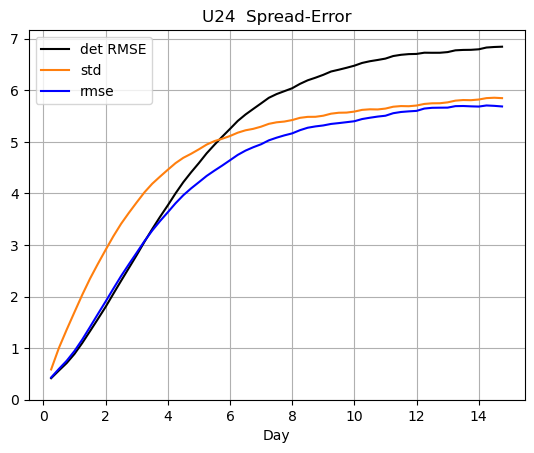

In [10]:
print(rollout_dir)
plot_slice(verif_rmse_lat, verif_std_lat, slice(-91, 91), '')


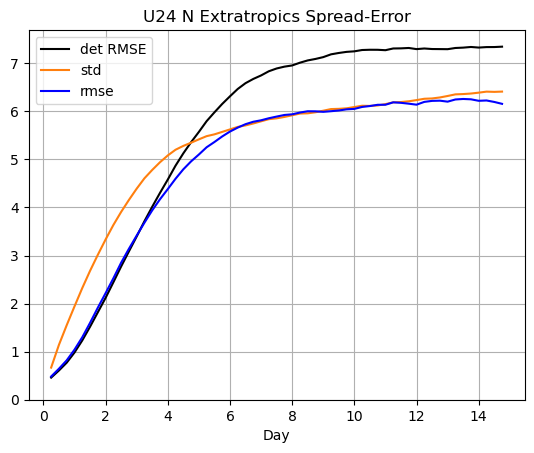

In [11]:
plot_slice(verif_rmse_lat, verif_std_lat, slice(24.5, 91), 'N Extratropics')

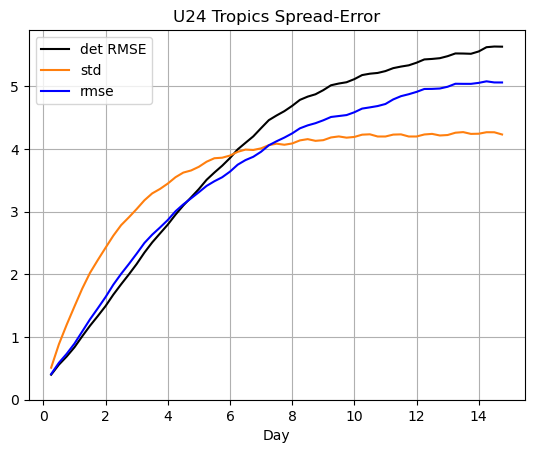

In [12]:
plot_slice(verif_rmse_lat, verif_std_lat, slice(-24.5, 24.5), 'Tropics')

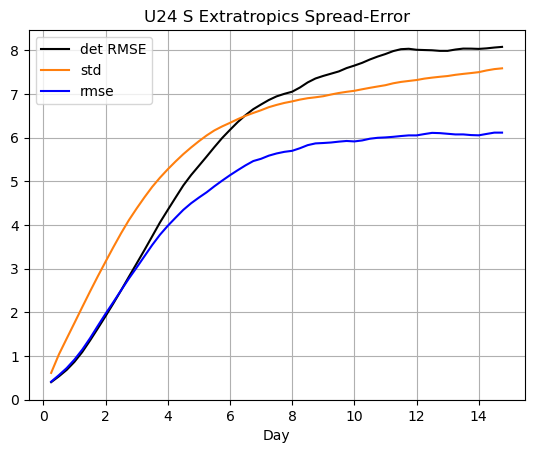

In [13]:
plot_slice(verif_rmse_lat, verif_std_lat, slice(-91, -24.5), 'S Extratropics')